In [1]:
%matplotlib inline

import sys
import os
import logging
import ast

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 50)
pd.set_option('display.max_colwidth', None)
from scipy import stats
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
sns.set(style='ticks')

## Read data

In [2]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)

In [3]:
dp = DataProvider(config)
df_og = dp.read_csv('exp_01_1e12.csv')
df_og['robust_cost'] = np.around(df_og['robust_cost'], 4)
df_og['nominal_cost'] = np.around(df_og['nominal_cost'], 4)
df_og['robust_throughput'] = 1 / df_og['robust_cost']
df_og['nominal_throughput'] = 1 / df_og['nominal_cost']
df_og['delta_throughput'] = (df_og['robust_throughput'] - df_og['nominal_throughput']) / df_og['nominal_throughput']
df_og['robust_rho'] = np.around(df_og['robust_rho'], 2)
df_og['delta_rho'] = df_og['robust_rho'] - df_og['rho_hat']

In [4]:
expected_bits_per_element = 10
df = df_og[df_og['M'] == expected_bits_per_element * df_og['N']]
df.describe()

,workload_idx,N,M,robust_rho,robust_m_filt,robust_T,robust_exit_mode,nominal_m_filt,nominal_T,rho_hat,sample_idx,nominal_cost,robust_cost,robust_throughput,nominal_throughput,delta_throughput,delta_rho
count,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06,2.880000e+06
mean,8.500000e+00,1.000000e+12,1.000000e+13,1.875000e+00,1.591551e+12,6.068566e+00,2.500000e-01,4.513584e+12,2.036149e+01,1.370811e+00,4.999500e+03,5.433083e+00,2.856948e+00,3.841903e-01,2.846031e-01,8.975711e-01,5.041894e-01
std,5.188128e+00,0.000000e+00,0.000000e+00,1.152443e+00,1.467004e+12,7.923591e+00,1.479020e+00,3.108009e+12,2.728624e+01,8.458692e-01,2.886752e+03,4.021566e+00,1.394618e+00,1.061931e-01,1.801172e-01,1.229928e+00,1.429552e+00
min,0.000000e+00,1.000000e+12,1.000000e+13,0.000000e+00,1.000000e+12,2.000000e+00,0.000000e+00,0.000000e+00,2.347467e+00,1.330878e-04,0.000000e+00,2.731000e-01,2.696000e-01,2.411894e-02,2.891210e-02,-9.033710e-01,-4.330997e+00
25%,4.000000e+00,1.000000e+12,1.000000e+13,9.375000e-01,1.000000e+12,4.660180e+00,0.000000e+00,2.529268e+12,5.166274e+00,6.975509e-01,2.499750e+03,2.642000e+00,2.335000e+00,3.241281e-01,1.304023e-01,1.866871e-02,-5.224609e-01
50%,8.500000e+00,1.000000e+12,1.000000e+13,1.875000e+00,1.000000e+12,4.998932e+00,0.000000e+00,4.506374e+12,5.883904e+00,1.300226e+00,4.999500e+03,3.542500e+00,2.698700e+00,3.705488e-01,2.822865e-01,2.003549e-01,5.055457e-01
75%,1.300000e+01,1.000000e+12,1.000000e+13,2.812500e+00,1.000000e+12,5.129537e+00,0.000000e+00,7.627896e+12,1.643895e+01,1.927153e+00,7.499250e+03,7.668575e+00,3.085200e+00,4.282655e-01,3.785011e-01,1.650593e+00,1.581084e+00
max,1.700000e+01,1.000000e+12,1.000000e+13,3.750000e+00,9.944595e+12,1.000000e+02,9.000000e+00,8.892605e+12,1.000000e+02,4.330997e+00,9.999000e+03,3.458760e+01,4.146120e+01,3.709199e+00,3.661662e+00,7.546819e+00,3.749867e+00


## Visualization Directory

In [5]:
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"

In [6]:
def set_style(fsz=14):
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
#     sns.set(font='serif')#, rc={'text.usetex' : True})
    # Make the background white, and specify the specific font family
#     sns.set_style("white", {
#         "font.family": "Linux Libertine",
#         "font.serif": ["Linux Libertine"]
#     })
    plt.rc('font', family='Linux Libertine')
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

## Plot histogram of KL divergence

In [7]:
def plot_KL_divergence_histogram(df, workload_idx, color='blue', hatch='', bins=50):
    ymin, ymax = (0.0, 0.22)
    df = df[df['workload_idx'] == workload_idx]
    if workload_idx == 0:
        bins = 20
    weights = np.ones_like(df.rho_hat) / len(df.rho_hat)
    n, bins, patches = plt.hist(df.rho_hat, bins=bins, weights=weights, color=color, rasterized=True, hatch=hatch)
    plt.xlabel('$I_{KL}(\hat{w}, w)$')
    plt.ylabel('Probability Density')
    plt.ylim([ymin, ymax])
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

In [8]:
def plot_overlapping_histogram(df):
    color1, color2 = ('tab:blue', 'orange')
    fig, ax0 = plot_KL_divergence_histogram(df, 0, color=color1, hatch='//')
    fig, ax1 = plot_KL_divergence_histogram(df, 1, color=color2, hatch='')
    legend_elements = [Patch(facecolor=color1, hatch='//', label=r'$w_0: (25\%, 25\%, 25\%, 25\%)$'),
                       Patch(facecolor=color2, hatch='', label=r'$w_1: (97\%, 1\%, 1\%, 1\%)$')]   
    l = plt.legend(handles=legend_elements, loc='right', shadow=False, 
                   bbox_to_anchor=(1., 0.85), frameon=False)
    return fig, [ax0, ax1]

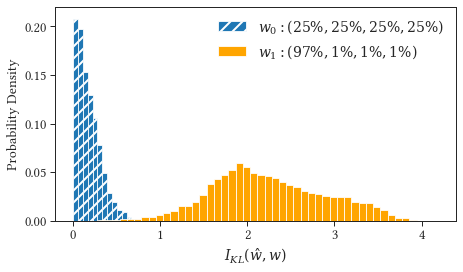

In [9]:
set_style()
fig, axes = plot_overlapping_histogram(df)
set_size(fig, 3.33 * 2, 2 * 2)
save_fig(fig, "KL_divergence_histogram.pdf")

## Plot changing scatter plot

In [10]:
def plot_three_scatterplots(df, workload_idx=11, rhos=[0, 0.25, 1, 2]):
    fig, axes = plt.subplots(nrows=1, ncols=len(rhos), sharey=True)
    plt.ylim(-1, 3.5)
    axes[0].set_ylabel(r'$\Delta_{\hat{w}}(\Phi_N, \Phi_R)$')
    df = df[df['workload_idx'] == workload_idx]
    dfs = []
    for rho in rhos:
        dfs.append(df[df.robust_rho == rho])
    
    for i in range(len(rhos)):
        robust_policy = 'Leveling' if dfs[i].iloc[0].robust_is_leveling_policy else 'Tiering'
        robust_T = np.around(dfs[i].iloc[0].robust_T, 1)
        robust_h = np.around(dfs[i].iloc[0].robust_m_filt / dfs[i].iloc[0].N, 1)
        
        df_pos = dfs[i][dfs[i].delta_throughput >= 0]
        df_neg = dfs[i][dfs[i].delta_throughput < 0]
        deltas_pos = df_pos.delta_throughput
        rho_hats_pos = df_pos.rho_hat
        deltas_neg = df_neg.delta_throughput
        rho_hats_neg = df_neg.rho_hat
        axes[i].scatter(rho_hats_pos, deltas_pos, s=5, color='tab:green', rasterized=True)
        axes[i].scatter(rho_hats_neg, deltas_neg, s=5, color='tab:gray', rasterized=True)
        axes[i].axhline(y=0, color='k', linestyle='--')
        axes[i].set_xlabel(r'$I_{KL}(\hat{w}, w_{' + str(workload_idx) + '})$')
        axes[i].set_title(r'$\rho:${}'.format(rhos[i]))
        rect = mpatches.Rectangle((-1, 0), 6, 4, linewidth=1, color='tab:green', fill=True, alpha=0.20)
        axes[i].add_patch(rect)
        axes[i].text(0, 2.2, f'Robust Tuning\n$\pi$:  {robust_policy}\nT:  {robust_T}\nh:  {robust_h}')

    wl = eval(df['w'].iloc[0])
    wl = [wl['z0'], wl['z1'], wl['q'], wl['w']]
    wl_str = f'({wl[0]:.0%}, {wl[1]:.0%}, {wl[2]:.0%}, {wl[3]:.0%})'
    axes[0].text(0, 1.5, '$w_{' + str(workload_idx) + '}$ = ' + wl_str)
    return fig, axes 

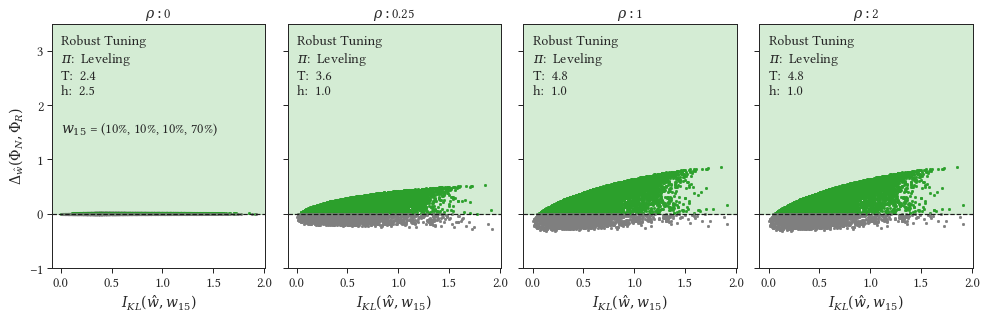

In [11]:
set_style()
fig, axes = plot_three_scatterplots(df, workload_idx=15)
set_size(fig, width=2*7, height=2*(2.33))
save_fig(fig, "scatterplot_evolution_rho.pdf")

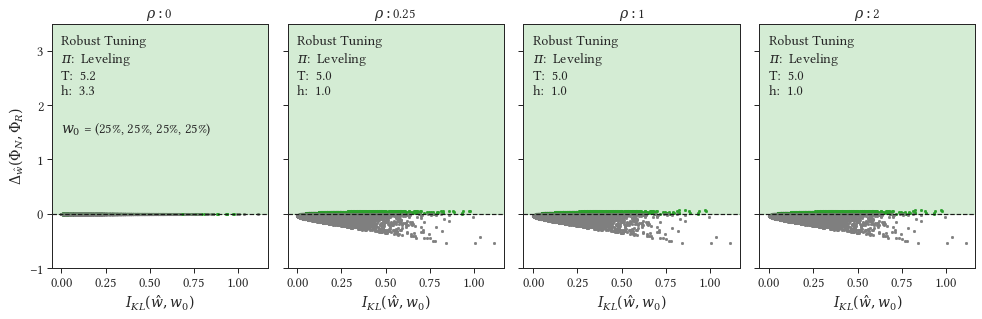

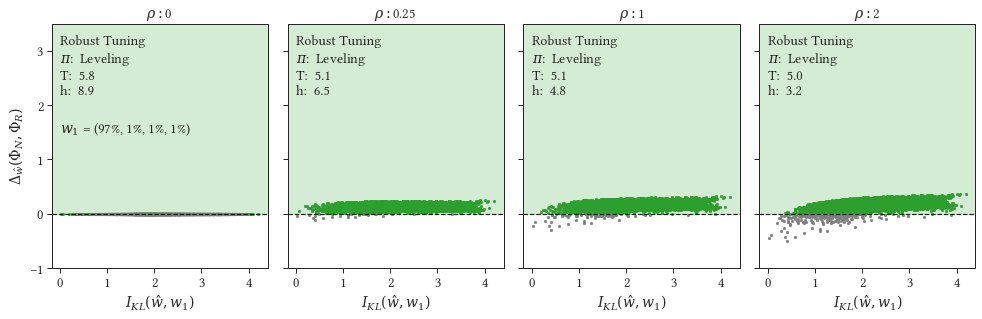

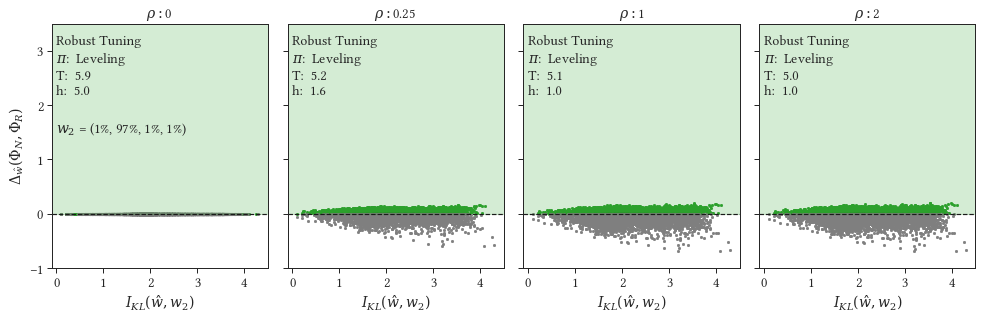

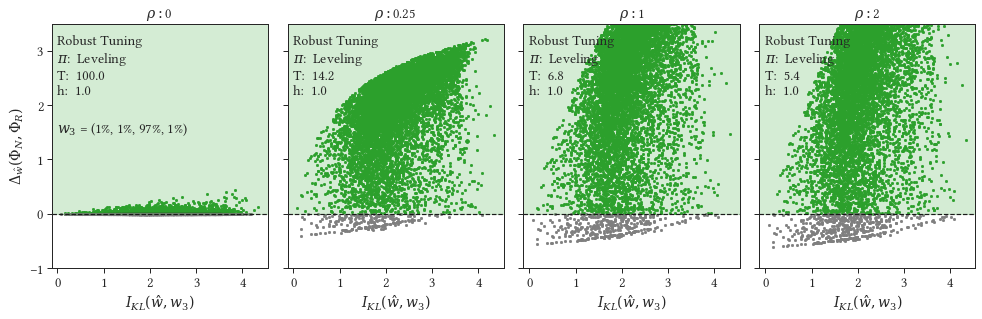

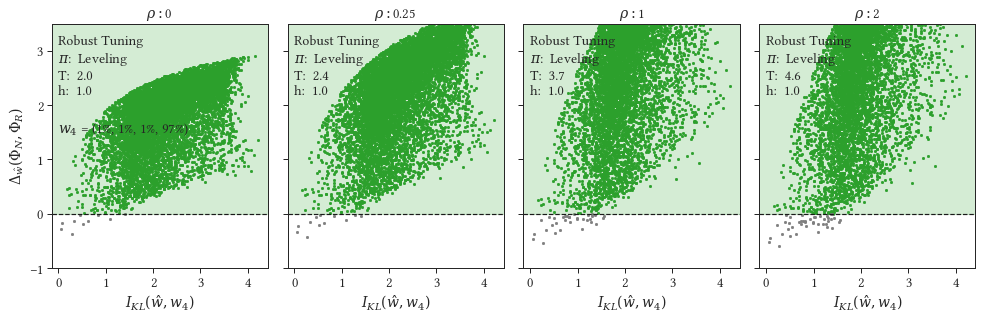

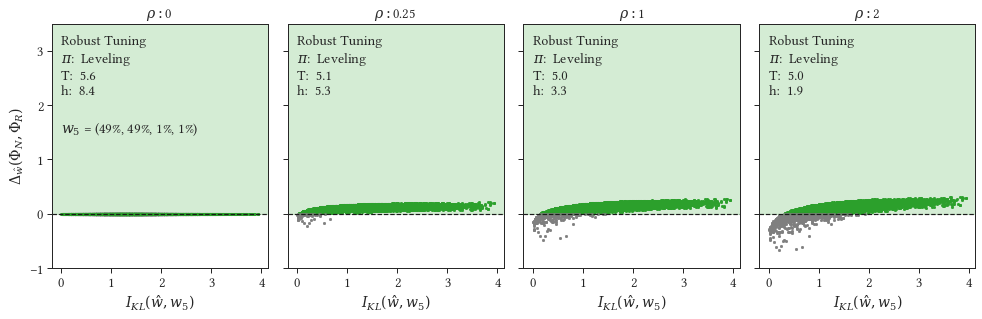

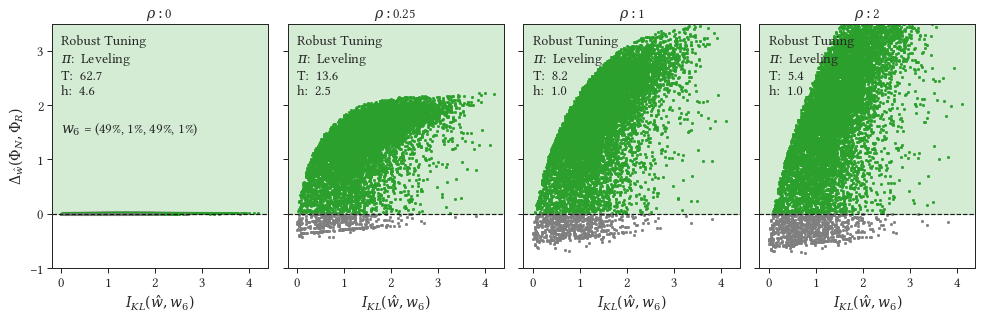

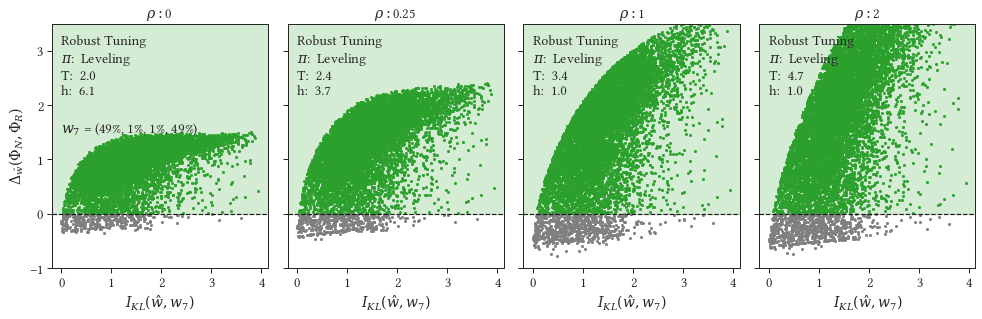

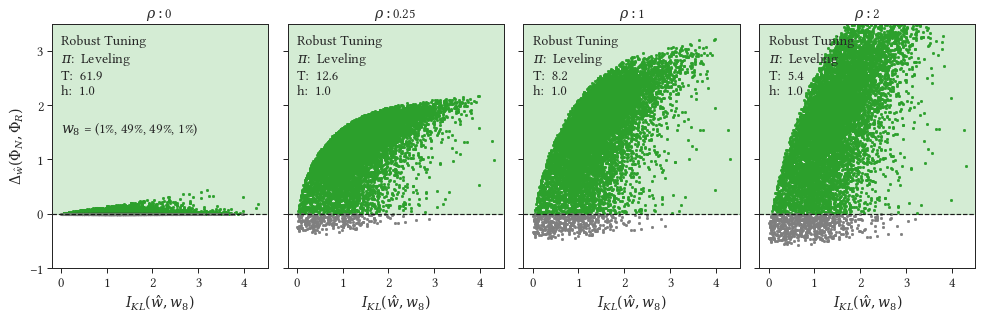

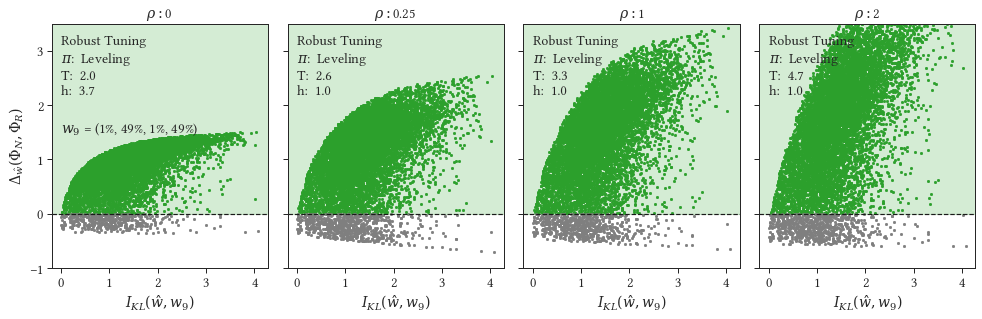

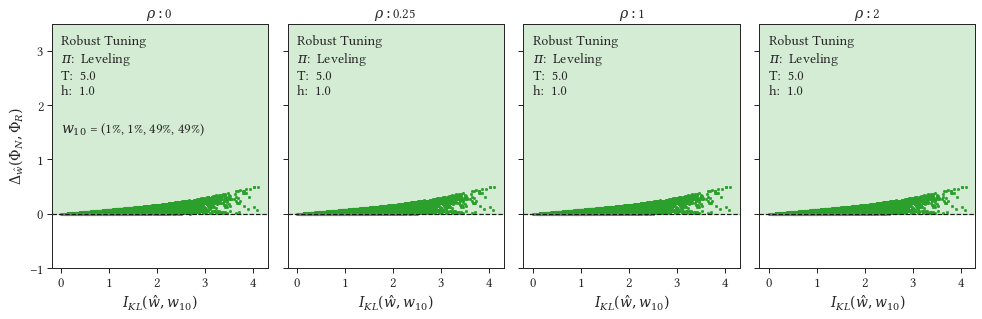

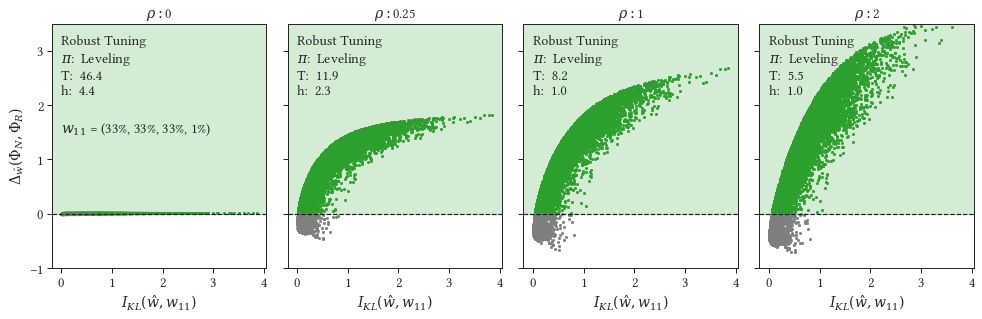

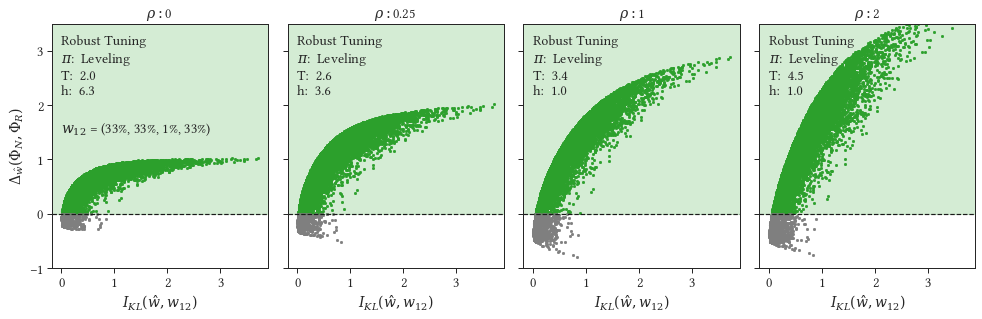

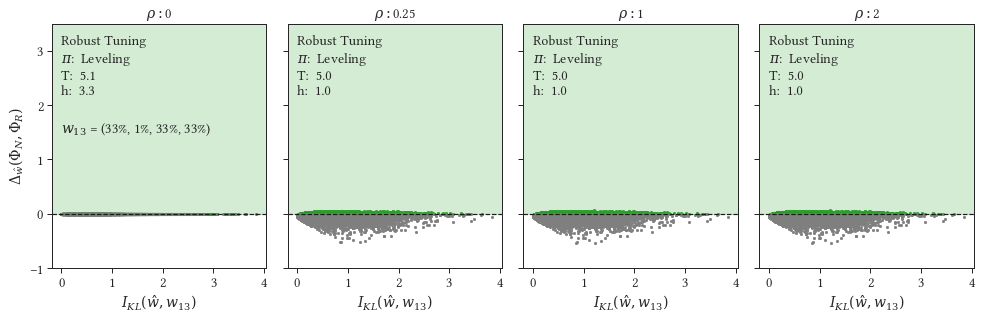

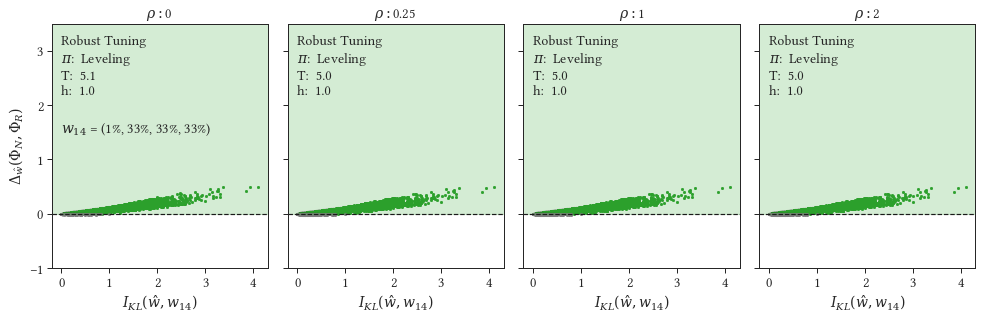

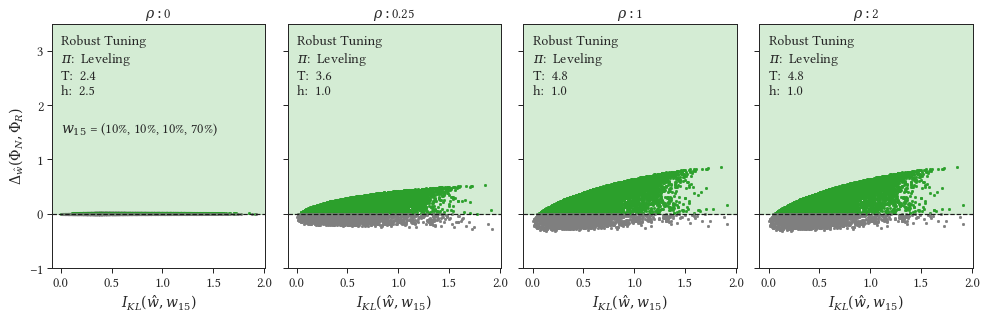

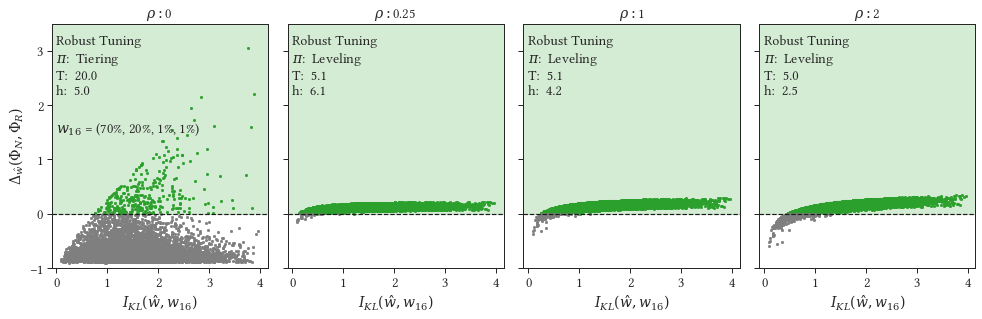

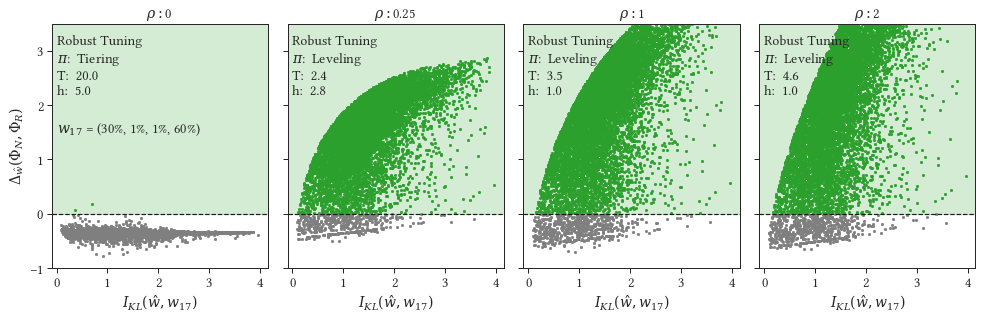

In [12]:
for wl_idx in range(18):
    fig, axes = plot_three_scatterplots(df, workload_idx=wl_idx)
    set_size(fig, width=2*7, height=2*(2.33))
    save_fig(fig, f'scatterplot_evolution_rho_wl{wl_idx}_1e12.pdf')

## Rho vs Rho hat

In [13]:
def plot_rho_vs_rho_hat(df, workload_idx):
    df = df[df.workload_idx == workload_idx]
    x1 = np.arange(df['robust_rho'].min(), df['robust_rho'].max(), 0.75)
    y1 = np.arange(df['rho_hat'].min(), df['rho_hat'].max(), 0.75)
    x2, y2 = np.meshgrid(x1, y1)
    
    z2 = scipy.interpolate.griddata((df['robust_rho'], df['rho_hat']), df['delta_throughput'], (x2, y2),
                                   method='linear')
    h = plt.contourf(x1, y1, z2, 10, cmap='RdGy')
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 20
    cbar.set_label('Delta Throughput', rotation=270)
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$I_{KL}(\hat{w}, w)$')
    plt.title(r'Workload Idx:{}'.format(workload_idx))
    ax = plt.gca()
    fig = plt.gcf()
    return fig, ax

In [14]:
def plot_rho_vs_rho_hat_grid(df, workloads=[5,7,11,12]):
    workloads = np.array(workloads).reshape((2,2))
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    for i in range(2):
        for j in range(2):
            plt.sca(axes[i, j])
            df0 = df[df.workload_idx == workloads[i][j]]
            w = eval(df[df.workload_idx == workloads[i][j]].iloc[0].w)
            w = [int(x*100) for x in w.values()]
            
            x1 = np.arange(0, 3.5, 0.5)
            y1 = np.arange(0, 3.5, 0.5)
            x2, y2 = np.meshgrid(x1, y1)
            z2 = scipy.interpolate.griddata((df0['robust_rho'], df0['rho_hat']), df0['delta_throughput'],
                                           (x2, y2), method='nearest')
            h = plt.contourf(x1, y1, z2, 10, cmap='RdYlGn')
            for c in h.collections:
                c.set_rasterized(True)
            cbar = plt.colorbar()
            cbar.ax.get_yaxis().labelpad = 10
            if j == 1:
                cbar.set_label('Norm. Delta Throuhgput: $\Delta_(\Phi_N, \Phi_R)$', rotation=270)
            if i == 1:
                plt.xlabel(r'$\rho$')
            if j == 0:
                plt.ylabel(r'$I_{KL}(\hat{w}, w)$')
            plt.title(r'$w$: ({}%, {}%, {}%, {}%)'.format(w[0], w[1], w[2], w[3]))
    return fig, axes        

In [15]:
def plot_rho_vs_rho_hat_row(df, workloads=[7,11]):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    for idx in range(2):
        plt.sca(axes[idx])
        df0 = df[df.workload_idx == workloads[idx]]
        w = eval(df[df.workload_idx == workloads[idx]].iloc[0].w)
        w = [int(x*100) for x in w.values()]

        x1 = np.arange(0, 3.5, 0.5)
        y1 = np.arange(0, 3.5, 0.5)
        x2, y2 = np.meshgrid(x1, y1)
        z2 = scipy.interpolate.griddata((df0['robust_rho'], df0['rho_hat']), df0['delta_throughput'],
                                       (x2, y2), method='nearest')
        h = plt.contourf(x1, y1, z2, 10, cmap='viridis')
        for c in h.collections:
            c.set_rasterized(True)
        cbar = plt.colorbar()
        cbar.ax.get_yaxis().labelpad = 10
        plt.title(f'$w_{{{workloads[idx]}}}$: ' + r'({}%, {}%, {}%, {}%)'.format(w[0], w[1], w[2], w[3]))
    fig.supxlabel(r'$\rho$', y=0.1)
    fig.supylabel(r'$I_{KL}(\hat{w}, w)$', x=0.05)
    cbar.set_label('$\Delta_{\hat{w}}(\Phi_N, \Phi_R)$', rotation=270, labelpad=30)
    return fig, axes        

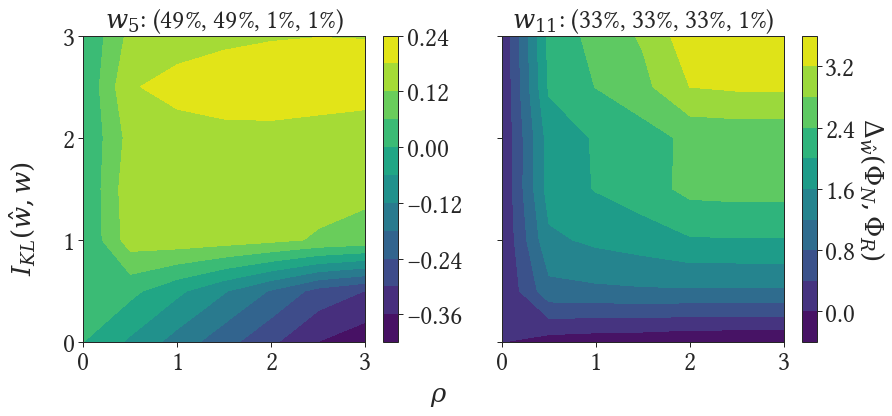

In [16]:
set_style(fsz=26)
fig, axes = plot_rho_vs_rho_hat_row(df, [5,11])
set_size(fig, width=4*3.33, height=4*1.66)
save_fig(fig, "rho_vs_rho_hat.pdf")

## Delta Throughput evolution with rho

In [190]:
def plot_delta_throughput_with_rho(df):
    uniforms = [0]
    unimodals = [1,2,3,4]
    bimodals = [5,6,7,8,9,10]
    trimodals = [11,12,13,14]
    
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Unimodals", marker="d", markersize=10,
                     color='tab:blue', data=df[df.workload_idx.isin(unimodals)])
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Bimodals", marker="X", markersize=10,
                     color='tab:green', data=df[df.workload_idx.isin(bimodals)])
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Trimodals", marker="o", markersize=10,
                     color='tab:orange', data=df[df.workload_idx.isin(trimodals)])
    g = sns.lineplot(x='robust_rho', y='delta_throughput', label="Uniform", marker="P", markersize=10,
                     color='tab:red', data=df[df.workload_idx.isin(uniforms)])
    
        
    l = g.legend(loc='right',
                 shadow=False,
                 frameon=True,
                 fancybox=False,
                 framealpha=1,
                 bbox_to_anchor=(1,0.21))
    
    plt.xlabel(r'$\rho}$')
    plt.ylabel(r'$\Delta_{\hat{w}}(\Phi_N, \Phi_R)$')
    plt.ylim([-0.1, 1.8])
    plt.xlim([0, 3.5])
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

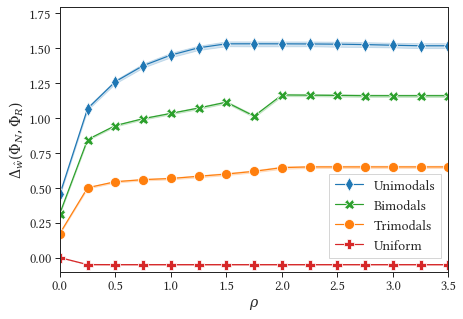

In [191]:
set_style()
fig, ax = plot_delta_throughput_with_rho(df)
set_size(fig, width=2*3.33, height=2*2.33)
save_fig(fig, "delta_throughput_workload_type.pdf")

In [186]:
def plot_throughput_range_evolution(df):
    df = df.copy()
    df['nominal_max_throughput'] = df['nominal_throughput']
    df['nominal_min_throughput'] = df['nominal_throughput']
    df['robust_max_throughput'] = df['robust_throughput']
    df['robust_min_throughput'] = df['robust_throughput']
    df = df.groupby(['workload_idx', 'robust_rho']).agg({'nominal_max_throughput':'max', 
                                                             'nominal_min_throughput': 'min',
                                                             'robust_max_throughput':'max', 
                                                             'robust_min_throughput': 'min'})
    df = df.reset_index()
    df['nominal_range'] = df['nominal_max_throughput'] - df['nominal_min_throughput']
    df['robust_range'] = df['robust_max_throughput'] - df['robust_min_throughput']
    g = sns.lineplot(x='robust_rho', y='nominal_range', color='tab:gray', marker="*", markersize=12,
                     label='Nominal', data=df)
    g = sns.lineplot(x='robust_rho', y='robust_range', color='tab:green', marker="o", markersize=7.5,
                     label='Robust', data=df)
    l = g.legend(shadow=False, frameon=False, bbox_to_anchor=(1.05, 0.5))
    
    plt.title(' ')
    plt.xlabel(r'$\rho}$')
    plt.ylabel(r'$\Theta_{\mathcal{B}}(\Phi)$')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

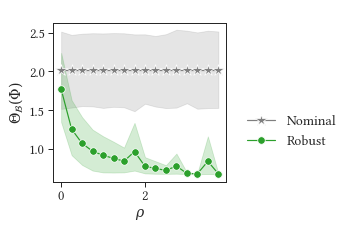

In [187]:
set_style()
fig, ax = plot_throughput_range_evolution(df)
set_size(fig, width=2*1.75, height=2*1.705)
save_fig(fig, 'throughput_range_evolution.pdf')

### Histogram of throughputs

In [188]:
def plot_overlapping_hist(df, workload_idx=11, rhos=[0, 0.25, 1, 2], bins=25):
    hist_range = (0, 1.5)
    wl_txt = str(workload_idx)
    fig, axes = plt.subplots(nrows=1, ncols=len(rhos), sharey=True)
    axes[0].set_ylabel(r'Delta Throughput')
    df = df[df['workload_idx'] == workload_idx]
    dfs = []
    for rho in rhos:
        dfs.append(df[df.robust_rho == rho])
        
    for i in range(len(rhos)):
        robust_policy = 'Leveling' if dfs[i].iloc[0].robust_is_leveling_policy else 'Tiering'
        robust_T = np.around(dfs[i].iloc[0].robust_T, 1)
        robust_h = np.around(dfs[i].iloc[0].robust_m_filt / dfs[i].iloc[0].N, 1)
        
        nominal_policy = 'Leveling' if dfs[i].iloc[0].nominal_is_leveling_policy else 'Tiering'
        nominal_T = np.around(dfs[i].iloc[0].nominal_T, 1)
        nominal_h = np.around(dfs[i].iloc[0].nominal_m_filt / dfs[i].iloc[0].N, 1)
        
        weights = np.ones_like(dfs[i]['nominal_throughput']) / len(dfs[i]['nominal_throughput'])
        axes[i].hist(dfs[i]['nominal_throughput'], weights=weights, bins=bins, alpha=1, 
                     color='tab:gray', range=hist_range)
        axes[i].hist(dfs[i]['robust_throughput'], weights=weights, bins=bins, alpha=0.8, 
                     color='tab:green', range=hist_range)
        axes[i].set_ylim(0, 0.5)
            
        
        axes[i].set_xlabel(r'$1$ / $C(\hat{w}_{' + wl_txt + '}, \Phi)$')
        if i == 0:
            axes[i].set_ylabel(r'Probability Density')
        axes[i].set_title(r'$\rho:${}'.format(rhos[i]))
        axes[i].add_patch(mpatches.Rectangle((0.38, 0.58), 0.5, 0.3,
                                             linewidth=1,
                                             color='tab:green',
                                             fill=True,
                                             alpha=0.2,
                                             transform=axes[i].transAxes))
        axes[i].text(0.405, 0.605, f'Robust\n$\pi$:  {robust_policy}\nT:  {robust_T}\nh:  {robust_h}', transform=axes[i].transAxes)
        
        if i == 0:
            axes[i].add_patch(mpatches.Rectangle((0.38, 0.16), 0.5, 0.3,
                                                 linewidth=1,
                                                 color='tab:gray',
                                                 fill=True,
                                                 alpha=0.2,
                                                 transform=axes[i].transAxes))
            axes[i].text(0.405, 0.185, f'Nominal\n$\pi$:  {nominal_policy}\nT:  {nominal_T}\nh:  {nominal_h}', transform=axes[i].transAxes)
            
    return fig, ax

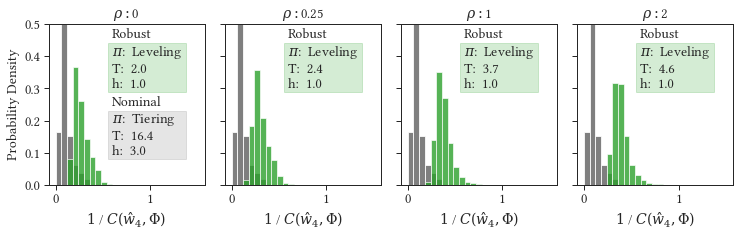

In [189]:
set_style()
fig, ax = plot_overlapping_hist(df, workload_idx=4)
set_size(fig, width=2*5.25, height=2*1.75)
save_fig(fig, 'overlapping_histogram.pdf')

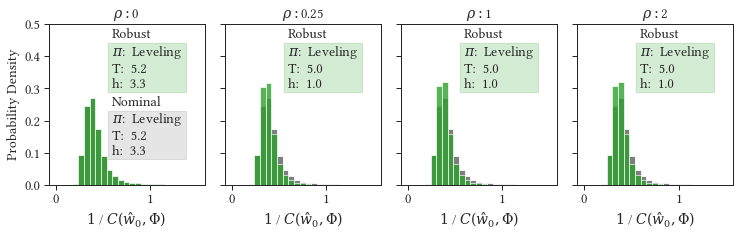

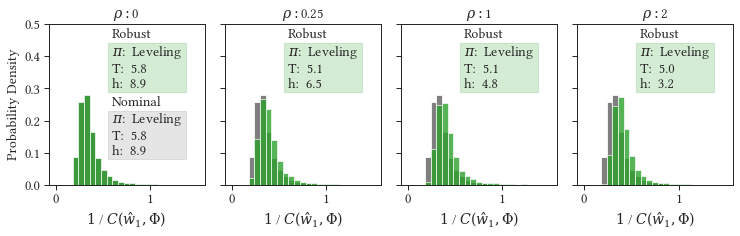

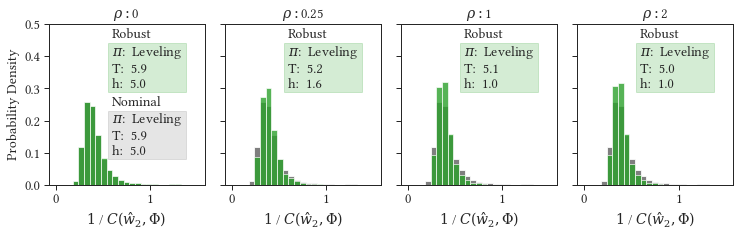

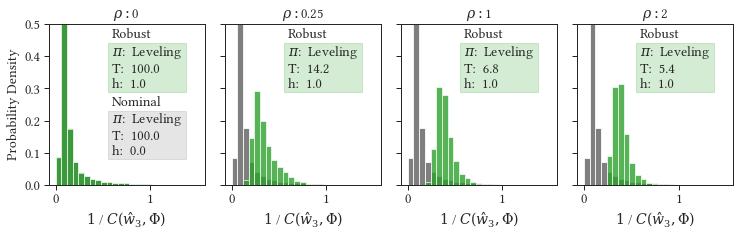

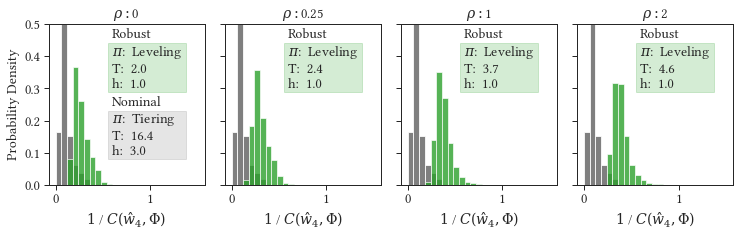

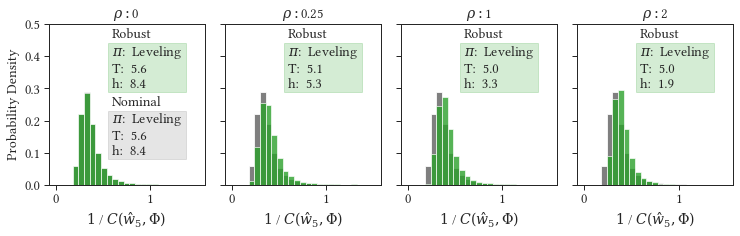

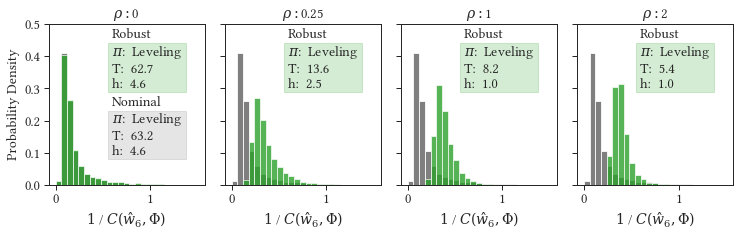

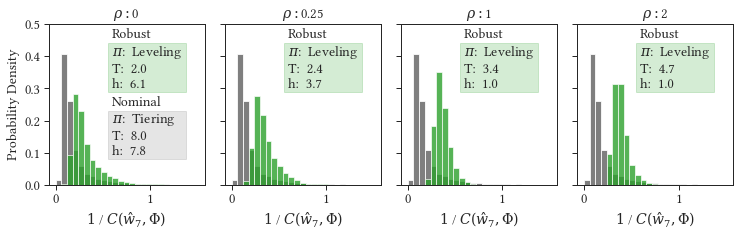

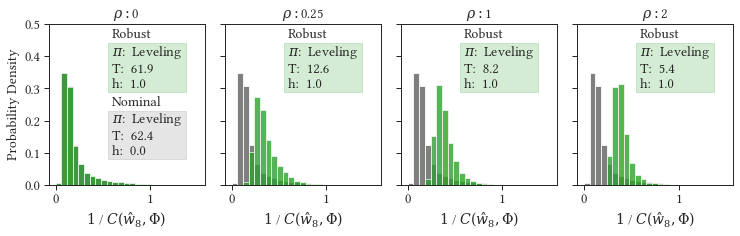

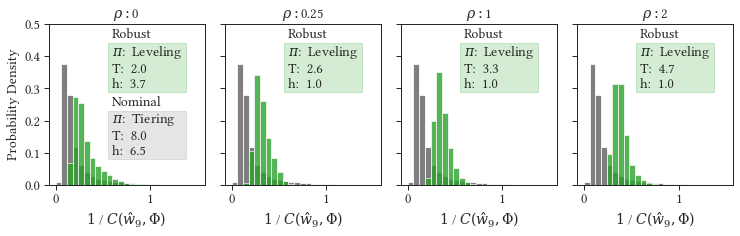

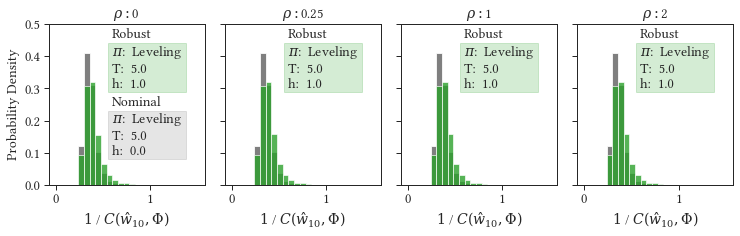

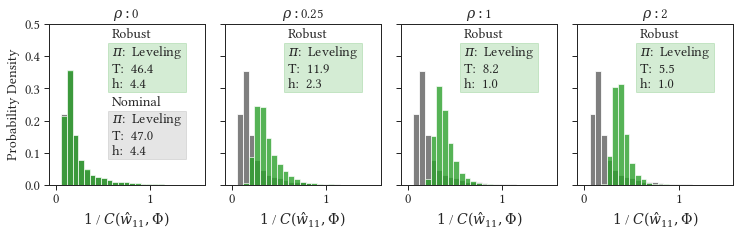

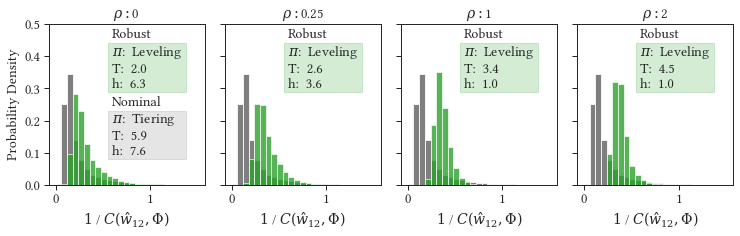

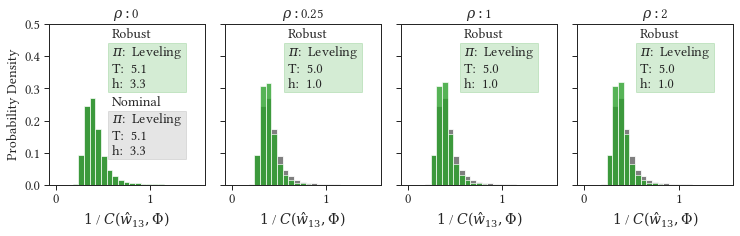

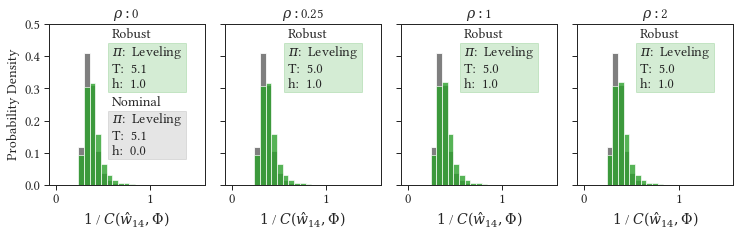

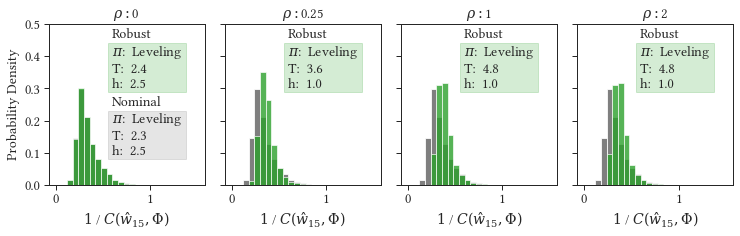

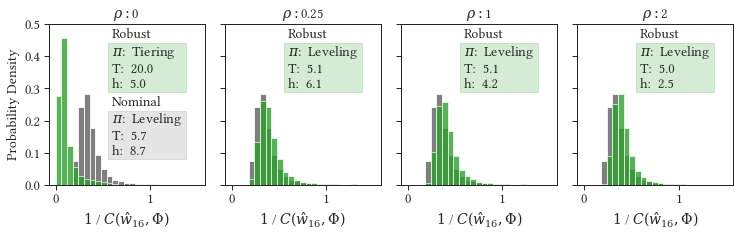

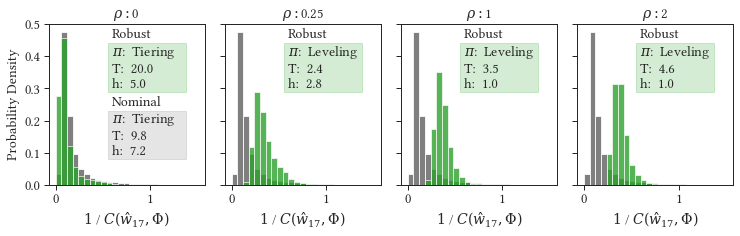

In [183]:
for wl_idx in range(18):
    set_style()
    fig, ax = plot_overlapping_hist(df, workload_idx=wl_idx)
    set_size(fig, width=2*5.25, height=2*1.75)
#     save_fig(fig, f'overlapping_histogram_wl{wl_idx}_1e12.pdf') 